In [ ]:
!pip install yfinance
!pip install ta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%capture
%%shell
cd /content/
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure --prefix=/usr
make
sudo make install
pip install TA-Lib

In [ ]:
# !pip install TA-Lib
# !pip install talib-binary
# !pip install talib-binary

### 1. Source of the data where you download the data from

### Data was sourced from yahoo finance using pandas datareader. The features were engineered with the ta library and the talib library. Both are used for extracting technical indicators from financial data.

### 2. Description of the dataset

### In order to find the best variables for forecasting, several python libraries were used as resources in order to abstract the features from the Sp500 stock price. First, the SP500 stock prices from yahoo finance starting from January 2001. From this, the following values were extracted: Open, High, Low, Close, Adj Close, and volume. The open price is the opening price at market start. The low price is the lowest price of the day. The close price is the last price when the market closes. The adjusted close is the close price adjusted for splits and dividends. The volume shows the amount of shares that traded hands that day. From these variables a multititude of features were extracted for the models. 

### Next, technical analysis features were extracted using a library in python called TA, short for technical analysis library. From this library 92 features were extracted. These indicators allow analysts to view the stocks in a multitude of different ways. The features from this library can be summarized into the following categories: Momentum Indicators, Volume Indicators, Volatility Indicators, Trend Indicators and 'Other' indicators which do not fit any of the other categories. 

### Finally, data was extracted using the TAlib, another technical analysis library, except from this libarary the candlestick patterns were obtained. The candlesticks patterns use the patterns of the open, high low and close prices to look for patterns such as the rounded cup, or head and shoulders pattern. These patterns tend to coincide with other techincal indicators indicating a biuy or sell signal for traders.

In [ ]:


import math   
import numpy as np 
import pandas as pd  
from datetime import date  
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler 
import yfinance as yf, pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
import seaborn as sns 
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import mplfinance as mpf
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
plt.style.use('seaborn')
# instantiate the model
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import numpy as np
#from candle_rankings import candle_rankings
import talib
from itertools import compress

sns.set_style('darkgrid', { 'axes.spines.right': False, 'axes.spines.top': False})


# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2000-01-01'

# Getting NASDAQ quotes
stockname = 'SP500'
symbol = '^GSPC'


import yfinance as yf 
df = yf.download(symbol, start=start_date, end=end_date)

# Quick overview of dataset
df.head()

Tensorflow Version: 2.9.2
Num GPUs: 0
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [ ]:
df_og = df.copy()
df_og.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

## Feature Engineering

In [ ]:
# Add all ta features
df2 = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.8/dist-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.8/dist-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [ ]:
print(len(df2.columns))
list(df2.columns)

92


['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a',
 'tren

In [ ]:
df2

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,-1.391598e+08,931800000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.061075,NaN,0.000000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-1.078670e+09,-77200000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.834467,-3.909918,-3.834467
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-6.739360e+08,1008300000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192218,0.192034,-3.649619
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,-5.139585e+08,2100600000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095568,0.095522,-3.557539
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,7.112415e+08,3325800000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.709040,2.672995,-0.944874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,4005.360107,4012.270020,3955.770020,3963.939941,3963.939941,3615430000,1.916821e+12,1241726030000,0.011446,2.062306e+10,...,1.463726,1.310362,0.153364,-9.415015,-4.218081,-5.196934,3896.283720,-1.544419,-1.556470,172.394553
2022-11-29,3964.189941,3976.770020,3937.649902,3957.629883,3957.629883,3546040000,1.916897e+12,1238179990000,0.036235,1.448038e+10,...,1.353277,1.318945,0.034332,-9.300356,-5.234536,-4.065820,3896.546053,-0.159187,-0.159313,171.960938
2022-11-30,3957.179932,4080.110107,3938.580078,4080.110107,4080.110107,6579360000,1.923477e+12,1244759350000,0.142405,1.275320e+11,...,1.497787,1.354714,0.143073,-3.046664,-4.796961,1.750298,3905.197838,3.094787,3.047864,180.377550


In [ ]:
df2

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,-1.391598e+08,931800000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22.061075,NaN,0.000000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,-1.078670e+09,-77200000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.834467,-3.909918,-3.834467
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,-6.739360e+08,1008300000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.192218,0.192034,-3.649619
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,-5.139585e+08,2100600000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095568,0.095522,-3.557539
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,7.112415e+08,3325800000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.709040,2.672995,-0.944874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,4005.360107,4012.270020,3955.770020,3963.939941,3963.939941,3615430000,1.916821e+12,1241726030000,0.011446,2.062306e+10,...,1.463726,1.310362,0.153364,-9.415015,-4.218081,-5.196934,3896.283720,-1.544419,-1.556470,172.394553
2022-11-29,3964.189941,3976.770020,3937.649902,3957.629883,3957.629883,3546040000,1.916897e+12,1238179990000,0.036235,1.448038e+10,...,1.353277,1.318945,0.034332,-9.300356,-5.234536,-4.065820,3896.546053,-0.159187,-0.159313,171.960938
2022-11-30,3957.179932,4080.110107,3938.580078,4080.110107,4080.110107,6579360000,1.923477e+12,1244759350000,0.142405,1.275320e+11,...,1.497787,1.354714,0.143073,-3.046664,-4.796961,1.750298,3905.197838,3.094787,3.047864,180.377550


In [ ]:
data=ticker.copy()

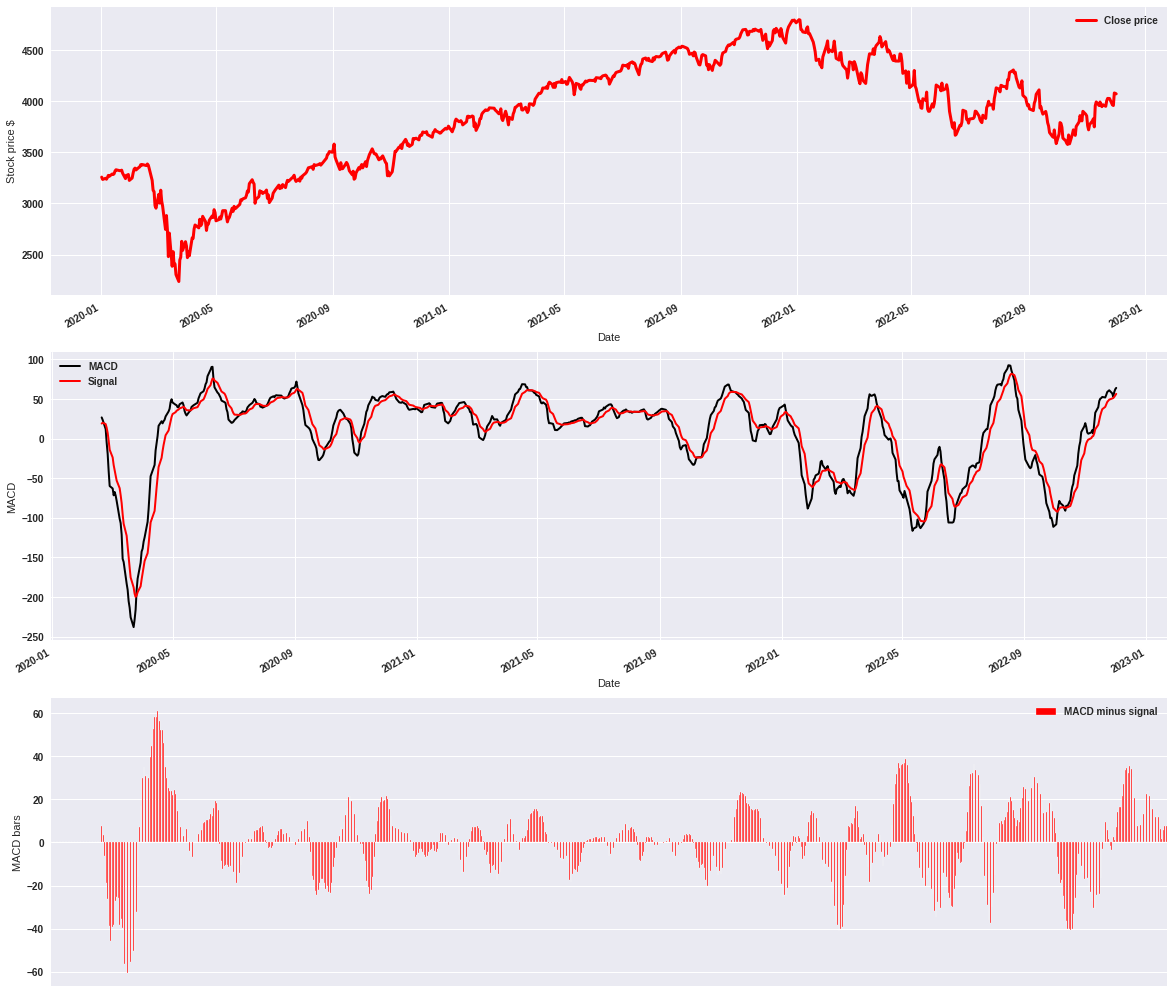

In [ ]:
# trim volume to avoid exponential form
import talib as ta
data['Volume'] = data['Volume'] / 1000

# macd
data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['Close'])

# # macd panel

MACD=data["macd"]
signal_MACD=data["macd_signal"]
bars=MACD-signal_MACD
bar_values=bars.values
bar_index_number=np.arange(0,len(bar_values))

with plt.style.context('seaborn'):
    import matplotlib
    font = { 'weight' : 'bold',
        'size'   : 14}
    matplotlib.rc('font', **font)
    fig = plt.figure(figsize=(20,20))
    ax1=fig.add_subplot(311, ylabel='Stock price $')
    data['Adj Close'].plot(ax=ax1,color='r',lw=3,label='Close price',legend=True)
    #ewm_short.plot(ax=ax1,color='b',lw=2,label=str(short_period)+'-exp moving average',legend=True)
    #ewm_long.plot(ax=ax1,color='m',lw=2,label=str(long_period)+'-exp moving average',legend=True)
    ax2=fig.add_subplot(312, ylabel='MACD')
    MACD.plot(ax=ax2,color='k',lw=2,label='MACD',legend=True)
    signal_MACD.plot(ax=ax2,color='r',lw=2,label='Signal',legend=True)
    ax3=fig.add_subplot(313, ylabel='MACD bars')
    x_axis = ax3.axes.get_xaxis()
    x_axis.set_visible(False)
    bars.plot(ax=ax3,color='r', kind='bar',label='MACD minus signal', legend=True,use_index=False)
    plt.savefig('MACD_spy.png')
    plt.show()
# # plot
# plots = [macd_plot, macd_signal_plot, macd_hist_plot]
# mpf.plot(data, type='candle',  mav=(50,100,200), addplot=plots, title=f"\n{'SP500'}", volume=False, volume_panel=2, ylabel='', ylabel_lower='')

In [ ]:
# plt.bar(bars)#, kind='bar',height)
# plt.plot(MACD)

In [ ]:
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',

('trend_macd_diff',)

In [ ]:
 from talib.abstract import *

inputs = {
    'open': df['Open'].astype(float),
    'high': df['High'].astype(float),
    'low': df['Low'].astype(float),
    'close': df['Close'].astype(float),
    'volume': df['Volume'].astype(float)
}
feats_df = pd.DataFrame()
feats_df['regression'] = pd.DataFrame(LINEARREG(inputs))
feats_df['ts_forecast'] = pd.DataFrame(TSF(inputs))
feats_df['variance'] = pd.DataFrame(VAR(inputs))
feats_df['abs_price_osc'] = pd.DataFrame(APO(inputs))
feats_df['balance_of_pwr'] = pd.DataFrame(BOP(inputs))
feats_df['chande_osc'] = pd.DataFrame(CMO(inputs))
feats_df['rate_change_ratio'] = pd.DataFrame(ROCR(inputs))
feats_df['double_ma'] = pd.DataFrame(DEMA(inputs))
feats_df.columns

Index(['regression', 'ts_forecast', 'variance', 'abs_price_osc',
       'balance_of_pwr', 'chande_osc', 'rate_change_ratio', 'double_ma'],
      dtype='object')

In [ ]:
feats_df.index = df2.index


### Creating candlestick feature patterns

In [ ]:


def recognize_candlestick(df):
    """
    Recognizes candlestick patterns 
    """

    op = df['Open'].astype(float)
    hi = df['High'].astype(float)
    lo = df['Low'].astype(float)
    cl = df['Close'].astype(float)

    candle_names = talib.get_function_groups()['Pattern Recognition']



    # create columns for each candle
    for candle in candle_names:
        # below is same as;
        # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
        df[candle] = getattr(talib, candle)(op, hi, lo, cl)


    df['candlestick_pattern'] = np.nan
    df['candlestick_match_count'] = np.nan
    for index, row in df.iterrows():

        # no pattern found
        if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
            df.loc[index,'candlestick_pattern'] = "NO_PATTERN"
            df.loc[index, 'candlestick_match_count'] = 0
        # single pattern found
        elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
            # bull pattern 100 or 200
            if any(row[candle_names].values > 0):
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bull'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1
            # bear pattern -100 or -200
            else:
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1


    
    return df


#

In [ ]:
pattern_df = recognize_candlestick(df_og).iloc[:,:-2]
list(pattern_df.columns)

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CDLPIERCING',
 'CDLRICKSHAWMAN',
 'CDLRISEFALL3METHODS',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR'

In [ ]:
len(pattern_df.columns)

67

In [ ]:
pattern_df.drop(['Open','High', 'Low', 'Close' ,'Adj Close', 'Volume'], axis = 1,inplace=True)

### 3. Load the dataset

In [ ]:
con_feats = pd.concat([feats_df,df2,pattern_df],axis=1)
con_feats

,regression,ts_forecast,variance,abs_price_osc,balance_of_pwr,chande_osc,rate_change_ratio,double_ma,Open,High,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,-0.353936,NaN,NaN,NaN,1469.250000,1478.000000,...,0,0,0,0,0,0,0,0,0,0
2000-01-04,NaN,NaN,NaN,NaN,-0.965565,NaN,NaN,NaN,1455.219971,1455.219971,...,0,0,0,0,0,0,0,0,0,0
2000-01-05,NaN,NaN,NaN,NaN,0.075581,NaN,NaN,NaN,1399.420044,1413.270020,...,0,0,0,0,0,0,0,0,0,0
2000-01-06,NaN,NaN,NaN,NaN,0.067675,NaN,NaN,NaN,1402.109985,1411.900024,...,0,0,0,0,0,0,0,0,0,0
2000-01-07,NaN,NaN,543.667916,NaN,0.933236,NaN,NaN,NaN,1403.449951,1441.469971,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,4028.370013,4040.245724,1014.892562,91.792106,-0.733100,11.478105,0.992740,3948.077359,4005.360107,4012.270020,...,0,0,0,0,0,0,0,0,0,0
2022-11-29,4012.447984,4020.450858,888.309668,84.017091,-0.167690,10.262804,1.000096,3952.678995,3964.189941,3976.770020,...,-100,0,0,0,0,0,0,0,0,0
2022-11-30,4012.957443,4017.395398,2066.446122,80.406336,0.868580,26.917136,1.022141,3972.020729,3957.179932,4080.110107,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(con_feats)

5768

In [ ]:
con2 = pd.DataFrame(con_feats)#.dtypes()
con2.dtypes

regression             float64
ts_forecast            float64
variance               float64
abs_price_osc          float64
balance_of_pwr         float64
                        ...   
CDLTHRUSTING             int32
CDLTRISTAR               int32
CDLUNIQUE3RIVER          int32
CDLUPSIDEGAP2CROWS       int32
CDLXSIDEGAP3METHODS      int32
Length: 161, dtype: object

### 4. Data cleaning and preprocessing

In [ ]:
# con_feats.drop(con_feats.columns[161], axis=1, inplace=True)
# con_feats

In [ ]:
#con_feats['candlestick_match_count'] = con_feats['candlestick_match_count'].replace(np.nan, 0)

In [ ]:

pd.set_option('display.max_rows', 500)

In [ ]:
print(con_feats.isna().sum())

regression                     13
ts_forecast                    13
variance                        4
abs_price_osc                  25
balance_of_pwr                  0
chande_osc                     14
rate_change_ratio              10
double_ma                      58
Open                            0
High                            0
Low                             0
Close                           0
Adj Close                       0
Volume                          0
volume_adi                      0
volume_obv                      0
volume_cmf                     19
volume_fi                      13
volume_em                       1
volume_sma_em                  14
volume_vpt                      0
volume_vwap                    13
volume_mfi                     13
volume_nvi                      0
volatility_bbm                 19
volatility_bbh                 19
volatility_bbl                 19
volatility_bbw                 19
volatility_bbp                 19
volatility_bbh

In [ ]:
con_feats.trend_psar_up

Date
2000-01-03            NaN
2000-01-04            NaN
2000-01-05            NaN
2000-01-06            NaN
2000-01-07            NaN
                 ...     
2022-11-28    3887.776174
2022-11-29    3905.325436
2022-11-30    3920.768786
2022-12-01    3937.649902
2022-12-02    3938.580078
Name: trend_psar_up, Length: 5768, dtype: float64

In [ ]:
feats_clean1 = con_feats.drop(['trend_psar_up', 'trend_psar_down'], axis = 1)

### 5. Handling missing values

In [ ]:
feats_clean1.dropna(inplace=True)

In [ ]:
# # Indexing Batches
# train_df = df.sort_values(by=['Date']).copy()

# # Adding Month and Year in separate columns
# d = pd.to_datetime(train_df.index)
# train_df['Day'] = d.strftime("%d") 
# train_df['Month'] = d.strftime("%m") 
# train_df['Year'] = d.strftime("%Y") 
train_df = df

In [ ]:
# Feature Engineering
def createFeatures(df):
    df = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Adj Close'].diff()
        
    # Moving averages - different periods
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA30'] = df['Close'].rolling(window=30).mean() 
    df['MA10'] = df['Close'].rolling(window=10).mean() 
    df['MA5'] = df['Close'].rolling(window=5).mean() 
    
    # SMA Differences - different periods
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
    # Exponential Moving Averages (EMAS) - different periods
    df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA30'] = df['Close'].ewm(span=30, adjust=False).mean()
    df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()


    # Replace nas 
    nareplace = df.at[df.index.max(), 'Close']    
    df.fillna((nareplace), inplace=True)
    
    return df

In [ ]:
# Create the dataset with features
df_features = createFeatures(feats_clean1)
df_features
# Shift the timeframe by 10 month
#use_start_date = pd.to_datetime("2010-11-01" )
#df_features = df_features[df_features.index > use_start_date].copy()


,regression,ts_forecast,variance,abs_price_osc,balance_of_pwr,chande_osc,rate_change_ratio,double_ma,Open,High,...,MA200_low,MA14_low,MA200_high,MA14_high,MA20dSTD,EMA10,EMA30,EMA50,EMA100,EMA200
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-14,1443.918293,1437.732097,2913.340768,8.570323,-0.830283,-38.895694,0.905230,1482.713144,1440.510010,1440.510010,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1356.560059,1356.560059,1356.560059,1356.560059,1356.560059
2000-04-17,1426.027134,1418.256475,2526.234996,1.118648,0.815553,-19.151709,0.930590,1473.956550,1356.560059,1401.530029,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1364.720037,1359.455535,1358.320054,1357.448769,1357.006625
2000-04-18,1421.615137,1413.900984,1494.227604,-5.859234,0.917126,-4.793053,0.964462,1471.007584,1401.439941,1441.609985,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1378.700028,1364.755822,1361.586326,1359.115328,1357.848449
2000-04-19,1412.535997,1404.089339,1020.494461,-15.028591,-0.603502,-8.952300,0.959728,1466.538830,1441.609985,1447.689941,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1387.567290,1368.801896,1364.169998,1360.468885,1358.541201
2000-04-20,1408.524864,1400.164845,961.740330,-21.675190,0.527222,-6.448250,0.955506,1463.348310,1427.469971,1435.489990,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1396.107790,1373.043067,1366.929608,1361.935641,1359.297408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,4028.370013,4040.245724,1014.892562,91.792106,-0.733100,11.478105,0.992740,3948.077359,4005.360107,4012.270020,...,3491.580078,3744.219971,4637.299805,4034.020020,100.178252,3968.079063,3891.596855,3876.596937,3917.131920,4021.061553
2022-11-29,4012.447984,4020.450858,888.309668,84.017091,-0.167690,10.262804,1.000096,3952.678995,3964.189941,3976.770020,...,3491.580078,3744.219971,4637.299805,4034.020020,100.519151,3966.179212,3895.857051,3879.774700,3917.933860,4020.430392
2022-11-30,4012.957443,4017.395398,2066.446122,80.406336,0.868580,26.917136,1.022141,3972.020729,3957.179932,4080.110107,...,3491.580078,3859.889893,4637.299805,4080.110107,106.570699,3986.893920,3907.744345,3887.630990,3921.145270,4021.024220


In [ ]:
dfs2 = df_features#.diff().dropna()#.diff()#.diff().dropna()
#dfs3 = dfs2.diff().dropna()
dfs2.columns

Index(['regression', 'ts_forecast', 'variance', 'abs_price_osc',
       'balance_of_pwr', 'chande_osc', 'rate_change_ratio', 'double_ma',
       'Open', 'High',
       ...
       'MA200_low', 'MA14_low', 'MA200_high', 'MA14_high', 'MA20dSTD', 'EMA10',
       'EMA30', 'EMA50', 'EMA100', 'EMA200'],
      dtype='object', length=181)

In [ ]:
dfs2

,regression,ts_forecast,variance,abs_price_osc,balance_of_pwr,chande_osc,rate_change_ratio,double_ma,Open,High,...,MA200_low,MA14_low,MA200_high,MA14_high,MA20dSTD,EMA10,EMA30,EMA50,EMA100,EMA200
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-14,1443.918293,1437.732097,2913.340768,8.570323,-0.830283,-38.895694,0.905230,1482.713144,1440.510010,1440.510010,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1356.560059,1356.560059,1356.560059,1356.560059,1356.560059
2000-04-17,1426.027134,1418.256475,2526.234996,1.118648,0.815553,-19.151709,0.930590,1473.956550,1356.560059,1401.530029,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1364.720037,1359.455535,1358.320054,1357.448769,1357.006625
2000-04-18,1421.615137,1413.900984,1494.227604,-5.859234,0.917126,-4.793053,0.964462,1471.007584,1401.439941,1441.609985,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1378.700028,1364.755822,1361.586326,1359.115328,1357.848449
2000-04-19,1412.535997,1404.089339,1020.494461,-15.028591,-0.603502,-8.952300,0.959728,1466.538830,1441.609985,1447.689941,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1387.567290,1368.801896,1364.169998,1360.468885,1358.541201
2000-04-20,1408.524864,1400.164845,961.740330,-21.675190,0.527222,-6.448250,0.955506,1463.348310,1427.469971,1435.489990,...,4071.699951,4071.699951,4071.699951,4071.699951,4071.699951,1396.107790,1373.043067,1366.929608,1361.935641,1359.297408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-28,4028.370013,4040.245724,1014.892562,91.792106,-0.733100,11.478105,0.992740,3948.077359,4005.360107,4012.270020,...,3491.580078,3744.219971,4637.299805,4034.020020,100.178252,3968.079063,3891.596855,3876.596937,3917.131920,4021.061553
2022-11-29,4012.447984,4020.450858,888.309668,84.017091,-0.167690,10.262804,1.000096,3952.678995,3964.189941,3976.770020,...,3491.580078,3744.219971,4637.299805,4034.020020,100.519151,3966.179212,3895.857051,3879.774700,3917.933860,4020.430392
2022-11-30,4012.957443,4017.395398,2066.446122,80.406336,0.868580,26.917136,1.022141,3972.020729,3957.179932,4080.110107,...,3491.580078,3859.889893,4637.299805,4080.110107,106.570699,3986.893920,3907.744345,3887.630990,3921.145270,4021.024220


### 2. Define your final goal in this analysis and what problem you are trying to solve. For example, you might want to build a predictive model to estimate an attribute using your data and a regression model, or a classification problem, or you just want to discover novel insights from your data using exploratory data analysis.

### The goal of this project is to predict the SP500 stock price using LSTM models. One model will utlize features selected  by the XGBoost algorithm. The other model will use features selected by the Boruta model. Model performance will be compared in order to determine the better feature selection model for forecasting the SP500 price.

## 3. Perform an exploratory data analysis:

In [ ]:
dfs2.Close

Date
2000-04-14    1356.560059
2000-04-17    1401.439941
2000-04-18    1441.609985
2000-04-19    1427.469971
2000-04-20    1434.540039
                 ...     
2022-11-28    3963.939941
2022-11-29    3957.629883
2022-11-30    4080.110107
2022-12-01    4076.570068
2022-12-02    4071.699951
Name: Close, Length: 5696, dtype: float64

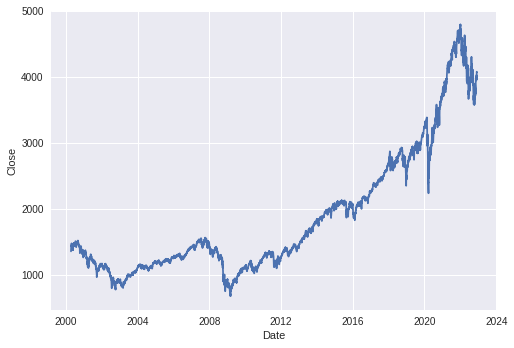

In [ ]:
sns.lineplot(x = 'Date', y = dfs2['Close'],data = dfs2)

### 3. Plot some variables over the others. Do you see any interesting relationships?

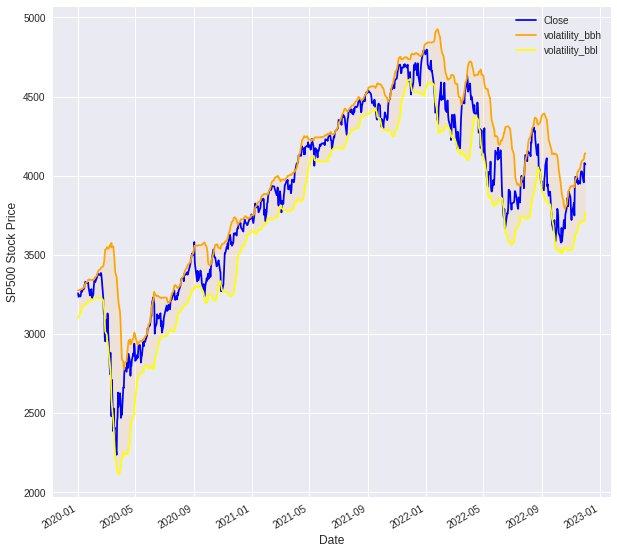

In [ ]:
 bb = ['Close','volatility_bbh','volatility_bbl']
ticker =  df.loc['2020-01-01':]
# # Boillinger band calculations
# ticker['TP'] = (ticker['Close'] + ticker['Low'] + ticker['High'])/3
# ticker['std'] = ticker['TP'].rolling(20).std(ddof=0)
# ticker['MA-TP'] = ticker['TP'].rolling(20).mean()
# ticker['BOLU'] = ticker['MA-TP'] + 2*ticker['std']
# ticker['BOLD'] = ticker['MA-TP'] - 2*ticker['std']
# ticker = ticker.dropna()
# print(ticker)
# Plotting it all together
#ax.set_ylabel('Example', fontsize=40)
ax = ticker[bb].plot(color=['blue', 'orange', 'yellow'],figsize=(10, 10))
#ax.tick_params(axis='x', labelsize=12 )
ax.set_xlabel('Date',fontsize=12 )
ax.set_ylabel('SP500 Stock Price',fontsize=12)
ax.fill_between(ticker.index, ticker['volatility_bbh'], ticker['volatility_bbl'], facecolor='orange', alpha=0.1)

plt.show()

### Above we can see the interaction with the bollinger bands. The bands are a volaility indicator. We can see as the price hits the bottom yellow band,the price shoots up, indicating that yellow bands acts as somewhat of a floor for the price.

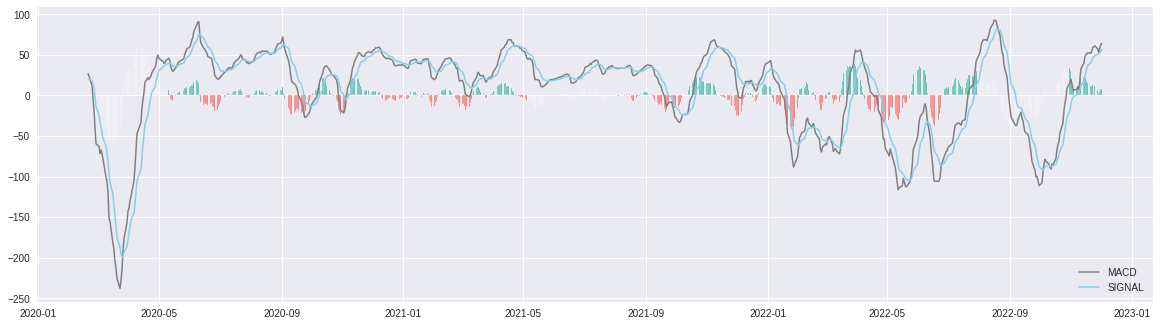

In [ ]:
def plot_macd(prices,bb, macd, signal, hist):
    #ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)
#ax = ticker[bb].plot(color=['blue', 'orange', 'yellow'],figsize=(10, 10))
    #ax1.plot(prices, color='lightblue')
    #ax1.plot(bb)
    #ax1.fill_between(ticker.index, ticker['volatility_bbh'], ticker['volatility_bbl'], facecolor='orange', alpha=0.1)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')
plt.style.use('seaborn')
plt.figure(figsize=(20,15))
plot_macd(data['Close'],ticker[bb], data["macd"], data["macd_signal"], data["macd_hist"])

### Above we can see the MACD signal and the MACD histogram features plotted together. AS the MACD line crosses over the signal from below, traders are given a buy signal. AS the MACD lines crosses over the signal from above, investors are given a sell signal.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


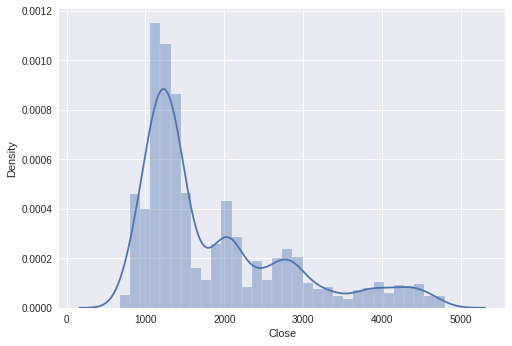

In [ ]:
sns.distplot(dfs2.Close)

### Here we see the close distribution, our target variable is skewed to the right. THe bulk of prices tend to be in the 1000-200 range.

In [ ]:
dfs2.columns

Index(['regression', 'ts_forecast', 'variance', 'abs_price_osc',
       'balance_of_pwr', 'chande_osc', 'rate_change_ratio', 'double_ma',
       'Open', 'High',
       ...
       'MA200_low', 'MA14_low', 'MA200_high', 'MA14_high', 'MA20dSTD', 'EMA10',
       'EMA30', 'EMA50', 'EMA100', 'EMA200'],
      dtype='object', length=181)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


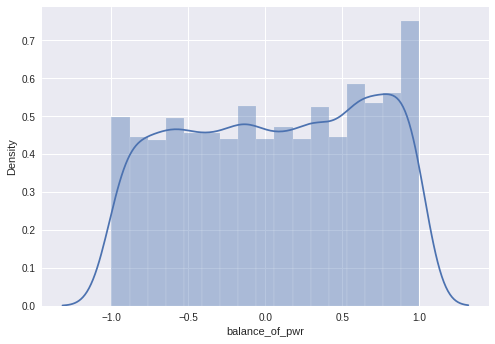

In [ ]:
sns.distplot(dfs2.balance_of_pwr)

### The balance of power takes value between -1 and 1. It seems it is almost flat except the right side of the histogram. The balance of power tells us whether there is systematic buying or selling.

### Feature Selection Using XGBoost

In [ ]:


X_var = dfs2.drop(['Close','Close_Diff'],axis=1)
y_var = dfs2.Close
y_scaled = StandardScaler().fit_transform(y_var.values.reshape(-1,1))
X_scaled =  StandardScaler().fit_transform(X_var) 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_var, test_size=0.2, random_state=42)



model = xgb.XGBRegressor(objective="reg:squarederror", colsample_bytree=0.3, learning_rate=0.01, max_depth=6, reg_alpha=15, n_estimators=1000, subsample=0.5)

# fit the model
model.fit(X_train, y_train, early_stopping_rounds=30, eval_metric=["rmse", "mae"], eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# extract the feature importances
thresholds = np.sort(model.feature_importances_)

# select the features
selection = SelectFromModel(model, threshold=np.mean(thresholds), prefit=True)

feature_idx = selection.get_support()
#feature_idx = model.get_support()
feature_name = X_var.columns[feature_idx]
print(feature_idx)
# array([ True,  True,  True, False, False])

selected_dataset = selection.transform(X_var)
print(selected_dataset.shape)
# (200, 3)

[0]	validation_0-rmse:2090.31	validation_0-mae:1857.52	validation_1-rmse:2064.61	validation_1-mae:1837.4
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 30 rounds.
[1]	validation_0-rmse:2069.6	validation_0-mae:1839.06	validation_1-rmse:2044.1	validation_1-mae:1819.11
[2]	validation_0-rmse:2049.1	validation_0-mae:1820.77	validation_1-rmse:2023.74	validation_1-mae:1800.96
[3]	validation_0-rmse:2028.8	validation_0-mae:1802.66	validation_1-rmse:2003.6	validation_1-mae:1783.01
[4]	validation_0-rmse:2008.7	validation_0-mae:1784.73	validation_1-rmse:1983.66	validation_1-mae:1765.21
[5]	validation_0-rmse:1988.84	validation_0-mae:1767	validation_1-rmse:1963.91	validation_1-mae:1747.61
[6]	validation_0-rmse:1969.11	validation_0-mae:1749.42	validation_1-rmse:1944.3	validation_1-mae:1730.14
[7]	validation_0-rmse:1949.62	validation_0-mae:1732.02	validation_1-rmse:1924.99	validation_1-mae:1712.9
[8]	val

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(5696, 23)


Text(0.5, 0, 'Xgboost Feature Importance')

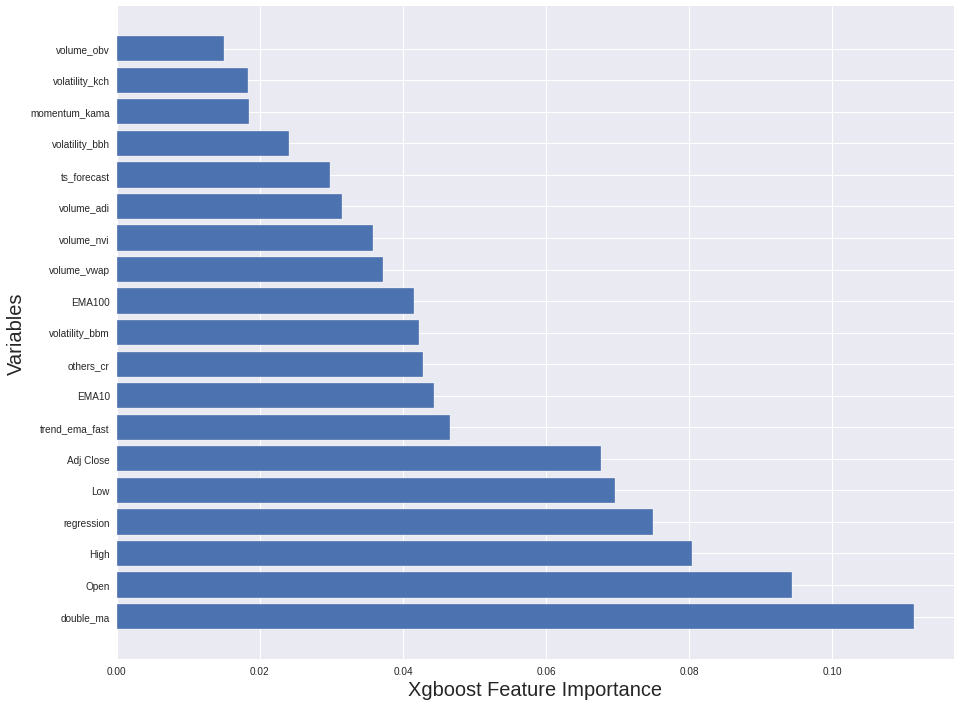

In [ ]:
sorted_idx = model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,12))
#plt.barh(X_var.columns[sorted_idx][:10], model.feature_importances_[sorted_idx][:10])
plt.barh(X_var.columns[sorted_idx][:19], model.feature_importances_[sorted_idx][:19])
plt.ylabel("Variables", fontsize=20)
plt.xlabel("Xgboost Feature Importance", fontsize=20)

In [ ]:
 model.feature_importances_[sorted_idx]

array([1.1144343e-01, 9.4394542e-02, 8.0441028e-02, 7.4993633e-02,
       6.9600910e-02, 6.7634970e-02, 4.6531912e-02, 4.4406191e-02,
       4.2816263e-02, 4.2192478e-02, 4.1535374e-02, 3.7255548e-02,
       3.5836276e-02, 3.1437650e-02, 2.9752390e-02, 2.4100088e-02,
       1.8498031e-02, 1.8305592e-02, 1.5038677e-02, 9.6063334e-03,
       9.5505901e-03, 7.7739796e-03, 7.4062045e-03, 5.4628248e-03,
       5.2523506e-03, 5.0774603e-03, 4.4961558e-03, 4.1156667e-03,
       3.7370941e-03, 3.5302939e-03, 2.9447849e-03, 2.3293344e-03,
       7.7223429e-04, 5.8324466e-04, 3.5644954e-04, 2.7917352e-04,
       2.1359899e-04, 8.3707957e-05, 6.7146844e-05, 5.2584965e-05,
       3.4136374e-05, 4.5513098e-06, 2.8236946e-06, 2.6231437e-06,
       2.4001747e-06, 2.3495015e-06, 2.0485252e-06, 1.7515061e-06,
       1.7221068e-06, 1.6559181e-06, 1.3100786e-06, 1.3044241e-06,
       1.1451928e-06, 1.1015898e-06, 1.0550031e-06, 1.0218600e-06,
       1.0053309e-06, 9.8335852e-07, 9.2543320e-07, 8.8466641e

In [ ]:
# plt.style.use('seaborn')
# plt.rcParams.update({'font.size': 12})
# sorted_idx = model.feature_importances_.argsort()
# plt.figure(figsize=(10,35))
# plt.tick_params(labelsize=12)
# plt.barh(X_var.columns, model.feature_importances_[sorted_idx])
# plt.ylabel("Variables", fontsize=20)
# plt.xlabel("Xgboost Feature Importance")

In [ ]:
dfs4 = pd.DataFrame(selected_dataset,columns=feature_name)
#selected_dataset.reset_index(inplace=True)
dfs4

,regression,ts_forecast,double_ma,Open,High,Low,Adj Close,volume_adi,volume_obv,volume_vwap,...,volatility_kcc,volatility_kch,volatility_dcl,trend_ema_fast,trend_ichimoku_b,momentum_kama,others_cr,MA5,EMA10,EMA100
0,1443.918293,1437.732097,1482.713144,1440.510010,1440.510010,1339.400024,1356.560059,1.837493e+09,3.927840e+09,1484.887205,...,1480.597664,1523.855660,1339.400024,1464.757451,1438.969971,1458.172335,-6.779725,4071.699951,1356.560059,1356.560059
1,1426.027134,1418.256475,1473.956550,1356.560059,1401.530029,1346.500000,1401.439941,3.038249e+09,5.132540e+09,1475.204768,...,1468.909334,1515.647335,1339.400024,1455.016296,1438.969971,1452.577256,-3.695663,4071.699951,1364.720037,1357.448769
2,1421.615137,1413.900984,1471.007584,1401.439941,1441.609985,1397.810059,1441.609985,4.147649e+09,6.241940e+09,1469.465428,...,1463.690670,1503.804671,1339.400024,1452.953786,1438.969971,1452.228701,-0.935253,4071.699951,1378.700028,1359.115328
3,1412.535997,1404.089339,1466.538830,1441.609985,1447.689941,1424.260010,1427.469971,3.420638e+09,5.240540e+09,1465.256256,...,1457.938997,1497.545992,1339.400024,1449.033199,1438.969971,1451.337049,-1.906928,4071.699951,1387.567290,1360.468885
4,1408.524864,1400.164845,1463.348310,1427.469971,1435.489990,1422.079956,1434.540039,4.189866e+09,6.136740e+09,1460.296941,...,1450.993665,1489.502661,1339.400024,1446.803482,1438.969971,1450.612925,-1.421086,1412.323999,1396.107790,1361.935641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,4028.370013,4040.245724,3948.077359,4005.360107,4012.270020,3955.770020,3963.939941,1.916821e+12,1.241726e+12,3942.835675,...,3978.847339,4021.970361,3698.149902,3957.905862,3762.800049,3896.283720,172.394553,3994.168018,3968.079063,3917.131920
5692,4012.447984,4020.450858,3952.678995,3964.189941,3976.770020,3937.649902,3957.629883,1.916897e+12,1.238180e+12,3953.162927,...,3977.161670,4018.939697,3698.149902,3957.863404,3762.800049,3896.546053,171.960938,3995.706006,3966.179212,3917.933860
5693,4012.957443,4017.395398,3972.020729,3957.179932,4080.110107,3938.580078,4080.110107,1.923477e+12,1.244759e+12,3976.190487,...,3981.330347,4029.694360,3698.149902,3976.670589,3785.845093,3905.197838,180.377550,4011.012012,3986.893920,3921.145270
5694,4032.769754,4038.934879,3988.955121,4087.139893,4100.509766,4050.870117,4076.570068,1.923637e+12,1.240232e+12,3989.003537,...,3992.388005,4042.840983,3698.149902,3992.039740,3796.044922,3919.271824,180.134286,4020.874023,4003.198674,3924.222989


In [ ]:
X_scaled

array([[-0.44424306, -0.45077805,  1.80672307, ..., -0.52999852,
        -0.52489543, -0.51562974],
       [-0.46278229, -0.47094437,  1.52347643, ..., -0.52815199,
        -0.5239507 , -0.51513934],
       [-0.46735411, -0.47545433,  0.76835302, ..., -0.52472511,
        -0.52217909, -0.5142149 ],
       ...,
       [ 2.21785408,  2.22037281,  1.18704731, ...,  2.12552475,
         2.20135615,  2.41033862],
       [ 2.23838405,  2.24267618,  1.70620044, ...,  2.13329844,
         2.20462788,  2.41094556],
       [ 2.25946968,  2.26609165,  2.01940599, ...,  2.14056691,
         2.20773231,  2.41149325]])

### 4. Final Analysis/Model Building

### 1. Build a model or perform any final analysis

In [ ]:
nrows = dfs4.shape[0]
np_data_unscaled = np.reshape(np.array(dfs4), (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = y_var.values.reshape((-1, 1))#pd.DataFrame(dfs['Close']).diff()
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(5696, 23)


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Split the training data into train and train data sets
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]

# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


print(x_train[1][sequence_length-1][0])
print(y_train[0])

(4507, 50, 1) (4507,)
(1139, 50, 1) (1139,)
0.0176459296849699
0.0176459296849699


In [ ]:
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1, activation='relu'))


# Configure the Model   
optimizer='adam'; loss='mean_squared_error'; epochs = 10019; batch_size = 64; patience = 8; 

# uncomment to customize the learning rate
learn_rate = .1#"standard" # 0.05
# adam = Adam(learn_rate=learn_rate) 

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], shuffle = True,
                  validation_data=(x_test, y_test))



timesteps: 50, features:1
Parameters: ['epochs 100', 'batch_size 64', 'patience 8', 'optimizer adam with learn rate 0.1', 'loss mean_squared_error']
Epoch 1/100
71/71 [==============================] - 18s 143ms/step - loss: 0.0524 - val_loss: 0.1834
Epoch 2/100
71/71 [==============================] - 9s 120ms/step - loss: 0.0439 - val_loss: 0.1246
Epoch 3/100
71/71 [==============================] - 9s 122ms/step - loss: 0.0439 - val_loss: 0.1150
Epoch 4/100
71/71 [==============================] - 9s 122ms/step - loss: 0.0440 - val_loss: 0.1015
Epoch 5/100
71/71 [==============================] - 9s 124ms/step - loss: 0.0439 - val_loss: 0.0892
Epoch 6/100
71/71 [==============================] - 9s 125ms/step - loss: 0.0439 - val_loss: 0.0634
Epoch 7/100
71/71 [==============================] - 9s 122ms/step - loss: 0.0439 - val_loss: 0.0721
Epoch 8/100
71/71 [==============================] - 9s 126ms/step - loss: 0.0439 - val_loss: 0.0611
Epoch 9/100
71/71 [=======================

### 5. Evaluating the Results

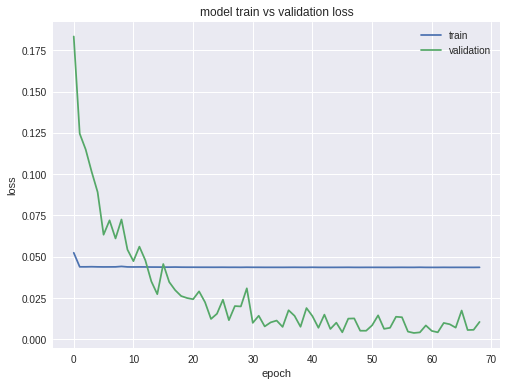

In [ ]:
# plot train and validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

36/36 [==============================] - 3s 30ms/step
Median Absolute Error (MAE): 93.15
Mean Absolute Percentage Error (MAPE): 2.43 %
Median Absolute Percentage Error (MDAPE): 1.94 %


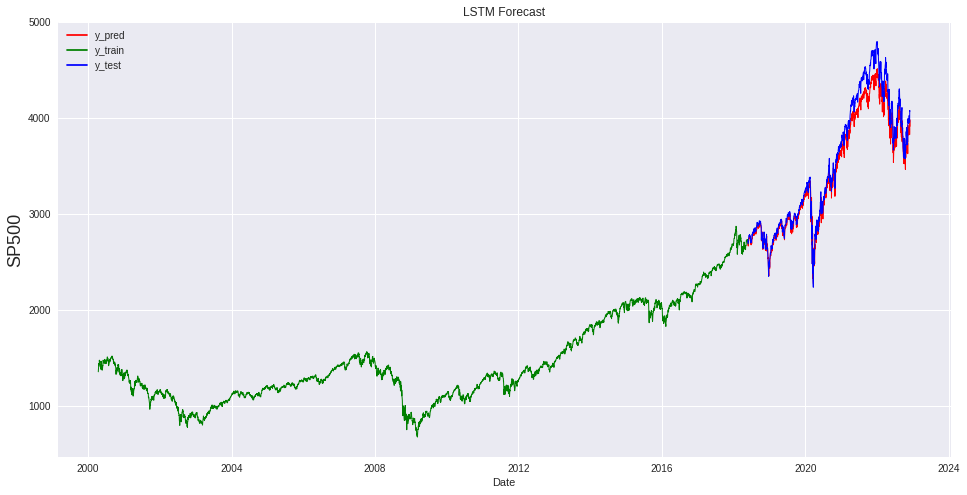

In [ ]:


# The date from which on the date is displayed
display_start_date = start_date 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(y_var[:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(y_var[train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Forecast")
plt.ylabel(stockname, fontsize=18)

sns.set_palette(['red','green','blue'])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)




In [ ]:
!pip install boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:

from boruta import BorutaPy

# instantiate random forest
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 'auto', random_state = 0)
boruta_selector.fit(np.array(X_var), np.array(y_var))

# store results
boruta_ranking = boruta_selector.ranking_
selected_features = np.array(X_var.columns)[boruta_ranking <= 2]

### Selected Features

In [ ]:
pd.DataFrame(selected_features).T.iloc[0,:]

0              regression
1             ts_forecast
2               double_ma
3                    Open
4                    High
5                     Low
6               Adj Close
7              volume_adi
8              volume_obv
9             volume_vwap
10             volume_nvi
11         volatility_bbm
12         volatility_bbh
13         volatility_kcc
14         volatility_kch
15         volatility_kcl
16         volatility_dch
17         volatility_dcm
18         trend_sma_fast
19         trend_sma_slow
20         trend_ema_fast
21         trend_ema_slow
22    trend_ichimoku_conv
23       trend_ichimoku_a
24       trend_ichimoku_b
25          momentum_kama
26              others_cr
27                  MA200
28                  MA100
29                   MA10
30                    MA5
31              MA200_low
32               MA14_low
33             MA200_high
34              MA14_high
35                  EMA10
36                  EMA30
37                  EMA50
38          

### Feature Selection Using Boruta Visualized dropped and kept features

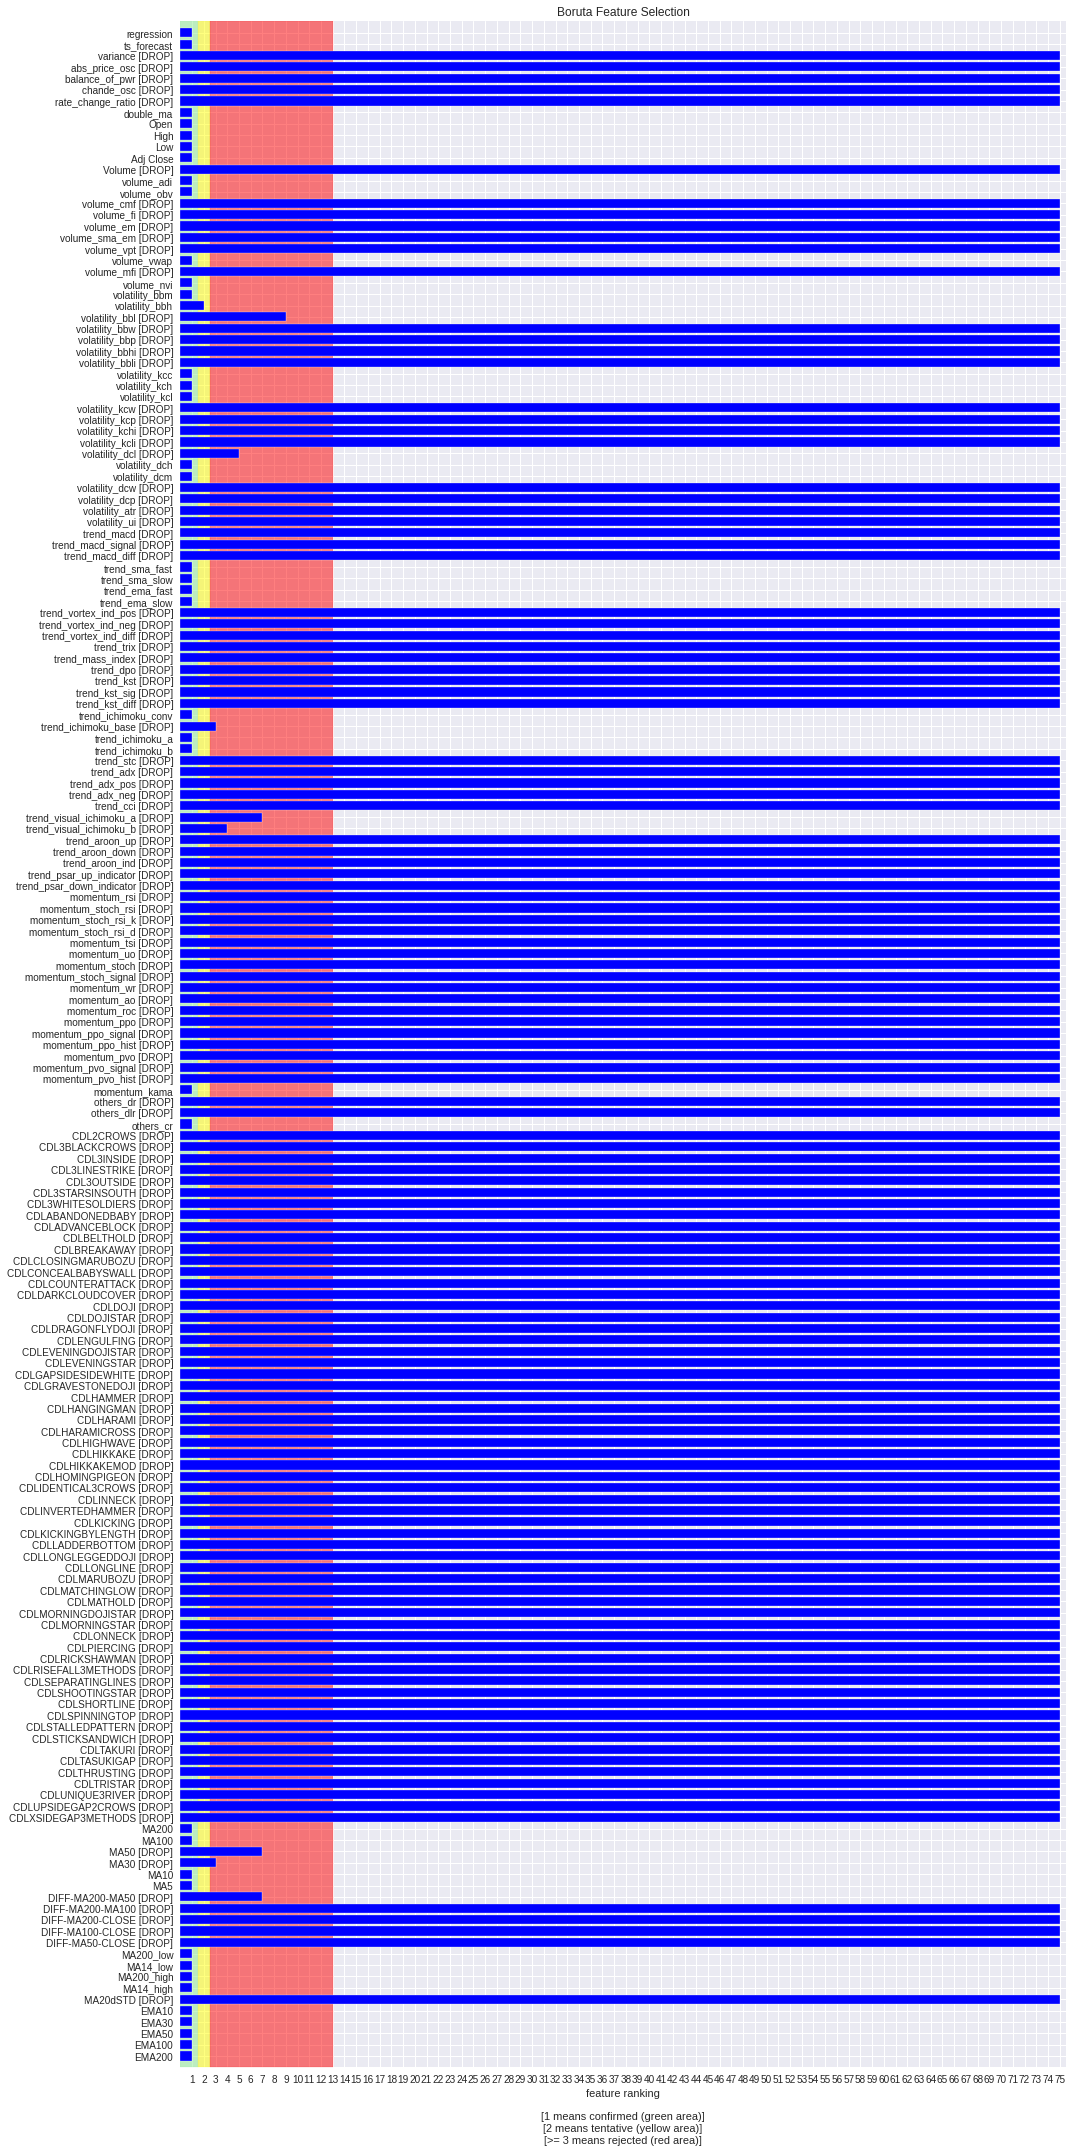

In [ ]:
fig, ax = plt.subplots(figsize = (15, 30))
feature_names = X_var.columns
ax.barh(range(len(feature_names)), boruta_ranking, color = 'blue', edgecolor = 'white')
ax.fill_between([0, 1.5], -1, len(feature_names), color = 'lightgreen', alpha = .5)
ax.fill_between([1.5, 2.5], -1, len(feature_names), color = 'yellow', alpha = .5)
ax.fill_between([2.5, 13], -1, len(feature_names), color = 'red', alpha = .5)
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels([feature_name + ' [DROP]' if boruta_ranking[i] > 2 else feature_name for i, feature_name in enumerate(feature_names)])
ax.set_xlim(0, boruta_ranking.max() + .5)
ax.set_ylim(-1, len(feature_names))
ax.set_xticks(range(1, boruta_ranking.max() + 1))
ax.set_xlabel('feature ranking\n\n[1 means confirmed (green area)]\n[2 means tentative (yellow area)]\n[>= 3 means rejected (red area)]')
ax.invert_yaxis()
ax.legend(loc="upper left")
ax.set_title('Boruta Feature Selection')
plt.tight_layout()
plt.savefig('ranking.png', dpi = 300)

In [ ]:
ds4 = selected_features
ds4

array(['regression', 'ts_forecast', 'double_ma', 'Open', 'High', 'Low',
       'Adj Close', 'volume_adi', 'volume_obv', 'volume_vwap',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_dch',
       'volatility_dcm', 'trend_sma_fast', 'trend_sma_slow',
       'trend_ema_fast', 'trend_ema_slow', 'trend_ichimoku_conv',
       'trend_ichimoku_a', 'trend_ichimoku_b', 'momentum_kama',
       'others_cr', 'MA200', 'MA100', 'MA10', 'MA5', 'MA200_low',
       'MA14_low', 'MA200_high', 'MA14_high', 'EMA10', 'EMA30', 'EMA50',
       'EMA100', 'EMA200'], dtype=object)

### LSTM-Boruta Model Creation

In [ ]:
nrows = dfs4.shape[0]
np_data_unscaled = np.reshape(np.array(dfs4), (nrows, -1))
print(np_data_unscaled.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = RobustScaler()
df_Close = y_var.values.reshape((-1, 1))#pd.DataFrame(dfs['Close']).diff()
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(5696, 23)


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50 # = number of neurons in the first layer of the neural network

# Split the training data into train and train data sets
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]


# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


print(x_train[1][sequence_length-1][0])
print(y_train[0])

(4507, 50, 1) (4507,)
(1139, 50, 1) (1139,)
0.0176459296849699
0.0176459296849699


In [ ]:
model = Sequential()

# Configure the Neural Network Model with n Neurons - inputshape = t Timestamps x f Features
n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=True))
#model.add(Dropout(0.1))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1, activation='relu'))


# Configure the Model   
optimizer='adam'; loss='mean_squared_error'; epochs = 100; batch_size = 64; patience = 8; 

# uncomment to customize the learning rate
learn_rate = .1
 

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer) + ' with learn rate ' + str(learn_rate), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))

# Compile and Training the model
model.compile(optimizer=optimizer, loss=loss)
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], shuffle = True,
                  validation_data=(x_test, y_test))



timesteps: 50, features:1
Parameters: ['epochs 100', 'batch_size 64', 'patience 8', 'optimizer adam with learn rate 0.1', 'loss mean_squared_error']
Epoch 1/100
71/71 [==============================] - 16s 140ms/step - loss: 0.0507 - val_loss: 0.2862
Epoch 2/100
71/71 [==============================] - 8s 118ms/step - loss: 0.0440 - val_loss: 0.1534
Epoch 3/100
71/71 [==============================] - 9s 124ms/step - loss: 0.0440 - val_loss: 0.1348
Epoch 4/100
71/71 [==============================] - 9s 125ms/step - loss: 0.0439 - val_loss: 0.1302
Epoch 5/100
71/71 [==============================] - 8s 116ms/step - loss: 0.0439 - val_loss: 0.0927
Epoch 6/100
71/71 [==============================] - 8s 118ms/step - loss: 0.0439 - val_loss: 0.0922
Epoch 7/100
71/71 [==============================] - 8s 117ms/step - loss: 0.0439 - val_loss: 0.0711
Epoch 8/100
71/71 [==============================] - 9s 122ms/step - loss: 0.0439 - val_loss: 0.0556
Epoch 9/100
71/71 [=======================

### Model Evaluation

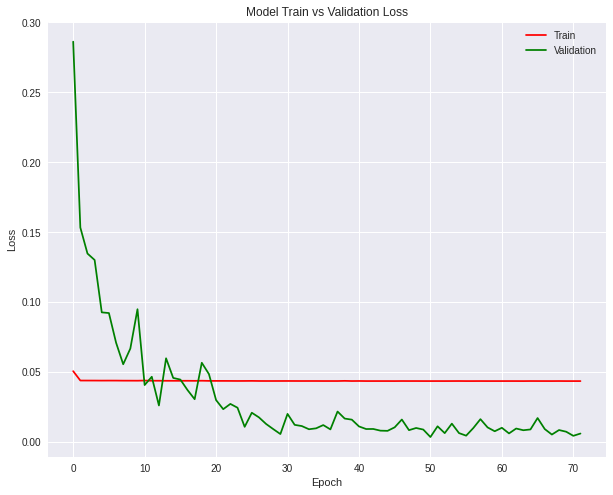

In [ ]:
# plot train and validation loss
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled.shape

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

36/36 [==============================] - 2s 23ms/step
Median Absolute Error (MAE): 65.76
Mean Absolute Percentage Error (MAPE): 1.75 %
Median Absolute Percentage Error (MDAPE): 1.23 %


In [ ]:
# plt.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='absolute errors', color=df_sub)
# plt.legend()
# plt.show()

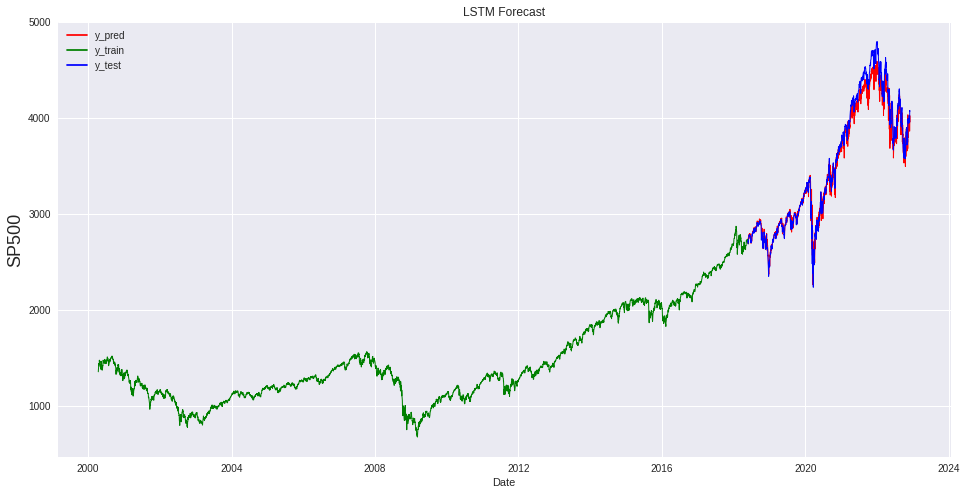

In [ ]:
# The date from which on the date is displayed
display_start_date = start_date 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(y_var[:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(y_var[train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Forecast")
plt.ylabel(stockname, fontsize=18)
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)


### 6. Discussion: Summarize your findings and analysis. What further analysis can be done?

The Boruta model outperformed the XGBoost model. The MAE for the XGboost model was 93.15, while the MAE for the Boruta model was 65.76. Therfore, the Boruta models performed approximately 43\% better than the XGBoost model. There may be several reasons for this. One reason may be the way the XGBoost features were selected. The features were selected only if they perfomed above average compared to the other features. This was somewhat arbtrarily chosen and perhaps a better method of selected which top n features exists. This may be the reason Boruta shined as it automatically selected the best features based on the statistical tests that it ran.

One covet to the Boruta model was that it was much more computationally expensive to compute results compared to the XGboost model, which was time consuming to run. Results were able to obtained much quicker with XGBoost.

The LST-XGboost model is able to make accurate predictions up until nearing the peak of the price history of the time series. There, it seems to have underestimated how high the stocks would go. One way this could be fixed is by lowering the threshold parameter to allow more features for a better prediction. Perhaps adding a higher learning rate could also be of benefit to the model.

 In the future it may be interesting to add more paramters and perhaps test out other methods of feature selection against Boruta. Also of interest if if we will see similar results on other models, for example a VARIMA model or Markov Chain-Monte Carlo model.